# Comparison of various Classification algorithms

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from graphviz import Source
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, f1_score
)

## Custom functions to evaluate models

In [2]:
# Define all the funcs to later evaluate models
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plt.matshow(cm, cmap="coolwarm", alpha=0.7)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(x=j, y=i, s=cm[i, j], ha='center', va='center')
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


def plot_precision_recall(y_true, y_probs, model_name="Model"):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    f1 = f1_score(y_true, (y_probs >= 0.5).astype(int))
    plt.figure()
    plt.plot(recall, precision,
             label=f"Precision-Recall Curve (F1 = {f1:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_name} Precision-Recall Curve")
    plt.legend()
    plt.show()


def plot_roc_curve(y_true, y_probs, model_name="Model"):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC Curve")
    plt.legend()
    plt.show()


df = pd.read_csv("test2.csv")
df.head(5)

,Version,Error Correction Level,Number of Blocks,Expected number of data codewords,Actual number of data codewords,Number of empty bytes,Number of EC Codewords,Errors corrected
0,2,L,1,34,34,0,10,0
1,10,L,4,274,274,0,18,0
2,1,L,1,19,19,0,7,0
3,3,M,1,44,44,0,26,0
4,2,M,1,28,27,1,16,8


## Dataframe preparation
This is just demonstration, this should be done while generating the csv, and based of the origin of the qr code (i.e. (malicious dataset) -> modified)

In [3]:
df['Modified'] = df['Number of empty bytes'].apply(lambda x: 1 if x > 0 else 0)
df['EC Level'] = df['Error Correction Level'].map(
    {'L': 1, 'M': 2, 'Q': 3, 'H': 4}).astype(int)

df.head(10)

,Version,Error Correction Level,Number of Blocks,Expected number of data codewords,Actual number of data codewords,Number of empty bytes,Number of EC Codewords,Errors corrected,Modified,EC Level
0,2,L,1,34,34,0,10,0,0,1
1,10,L,4,274,274,0,18,0,0,1
2,1,L,1,19,19,0,7,0,0,1
3,3,M,1,44,44,0,26,0,0,2
4,2,M,1,28,27,1,16,8,1,2
5,5,L,1,108,108,0,26,0,0,1
6,2,L,1,34,28,6,10,5,1,1
7,2,L,1,34,34,0,10,0,0,1
8,10,L,4,274,274,0,18,0,0,1
9,1,L,1,19,19,0,7,0,0,1


In [4]:
train_X = df[['Version', 'EC Level', 'Number of empty bytes',
              'Errors corrected']]
# this is to be determined later whether or not we limit ourselves to just
# these features or not
train_X.head(10)

,Version,EC Level,Number of empty bytes,Errors corrected
0,2,1,0,0
1,10,1,0,0
2,1,1,0,0
3,3,2,0,0
4,2,2,1,8
5,5,1,0,0
6,2,1,6,5
7,2,1,0,0
8,10,1,0,0
9,1,1,0,0


In [5]:
train_y = df['Modified']
train_y.head(10)

0    0
1    0
2    0
3    0
4    1
5    0
6    1
7    0
8    0
9    0
Name: Modified, dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train_X,
                                                    train_y, test_size=0.3,
                                                    random_state=1)

X_train.head(10)

# print("Test set size: " + str(X_test.size))
# print("Train set size: " + str(X_train.size))

,Version,EC Level,Number of empty bytes,Errors corrected
52,3,2,0,0
35,2,1,0,0
26,5,1,0,0
45,3,2,0,0
54,5,1,0,0
27,2,1,6,5
34,2,1,6,5
13,2,1,6,5
22,10,1,0,0
47,5,1,0,0


## Decison Tree

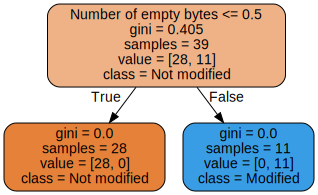

In [7]:
dtc = tree.DecisionTreeClassifier(random_state=42, criterion="entropy", max_depth=2)
# Using gini as criterion
dtc_gini = tree.DecisionTreeClassifier(random_state=42, criterion="gini", max_depth=2)

clf = dtc.fit(X_train, y_train)
clf2 = dtc_gini.fit(X_train, y_train)

feature_names = X_train.columns
class_names = ['Not modified', 'Modified']

export_graphviz(
    clf,
    out_file="test.dot",
    feature_names=feature_names,
    class_names=class_names,
    rounded=True,
    filled=True,
)

# Also export DT with gini as criterion
export_graphviz(
    dtc_gini,
    out_file="test_gini.dot",
    feature_names=feature_names,
    class_names=class_names,
    rounded=True,
    filled=True,
)

dtc_pred = clf.predict(X_test)
dtc_probs = clf.predict_proba(X_test)[:, 1]
dtc_gini_pred = clf2.predict(X_test)

Source.from_file("test_gini.dot")
#Source.from_file("test.dot")

## Decision Tree evaluation

<Figure size 640x480 with 0 Axes>

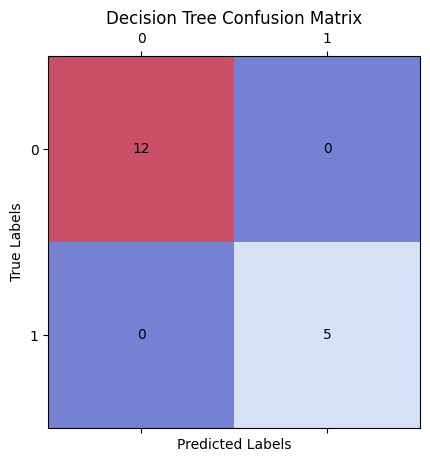

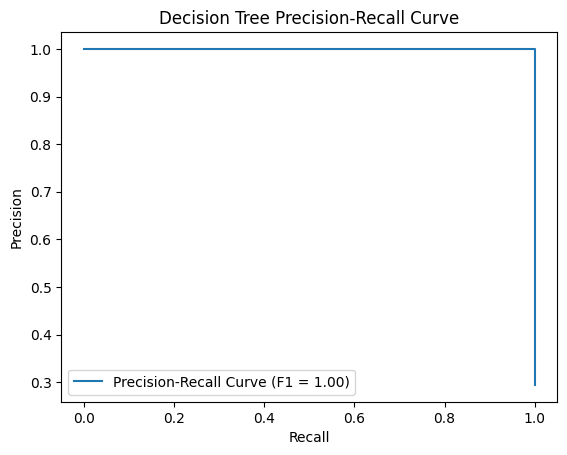

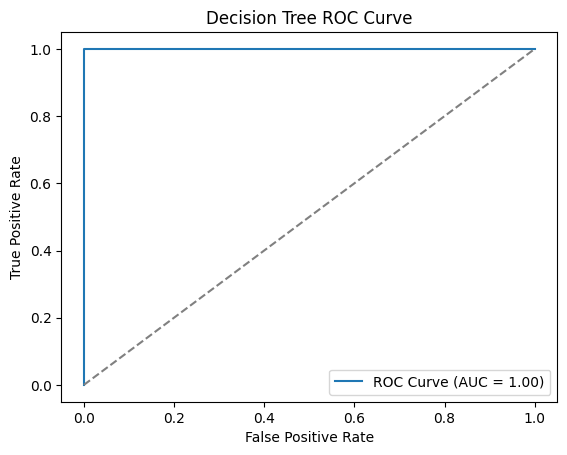

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         5

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



In [8]:
plot_confusion_matrix(y_test, dtc_pred, title="Decision Tree Confusion Matrix")
plot_precision_recall(y_test, dtc_probs, model_name="Decision Tree")
plot_roc_curve(y_test, dtc_probs, model_name="Decision Tree")
print(classification_report(y_test, dtc_pred))

## Random Forest

<Figure size 640x480 with 0 Axes>

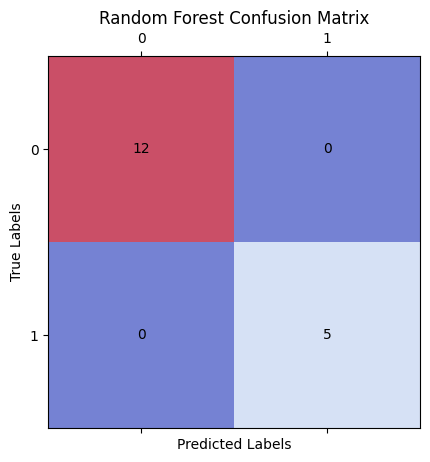

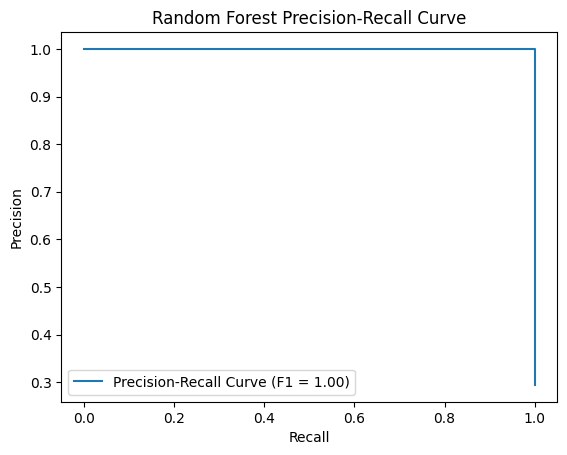

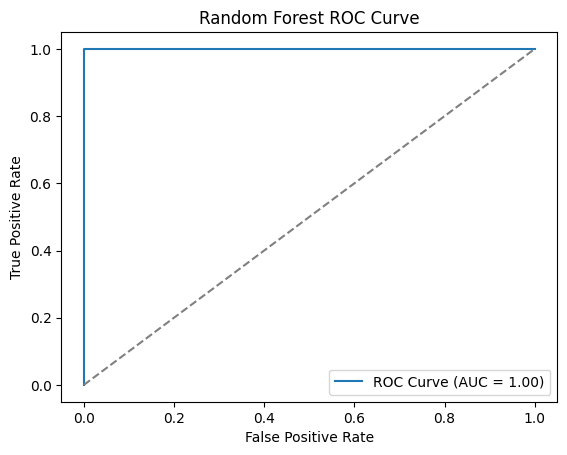

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         5

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



In [9]:
rf = RFC(random_state=1234, criterion="entropy", n_estimators=10, max_depth=3)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1]

plot_confusion_matrix(y_test, rf_pred, title="Random Forest Confusion Matrix")
plot_precision_recall(y_test, rf_probs, model_name="Random Forest")
plot_roc_curve(y_test, rf_probs, model_name="Random Forest")
print(classification_report(y_test, rf_pred))

## K-Nearest Neighbours

<Figure size 640x480 with 0 Axes>

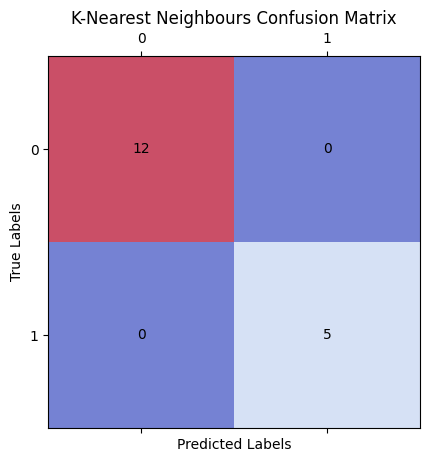

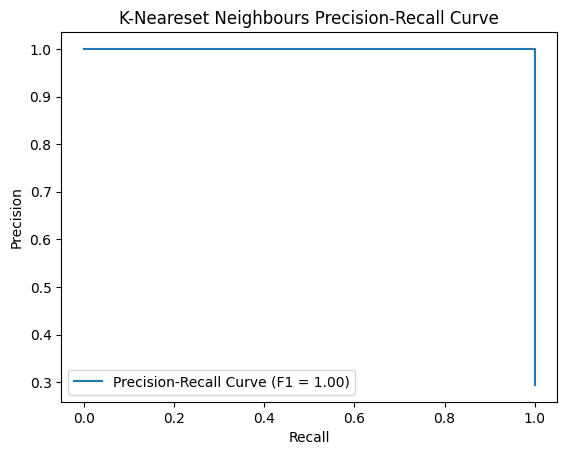

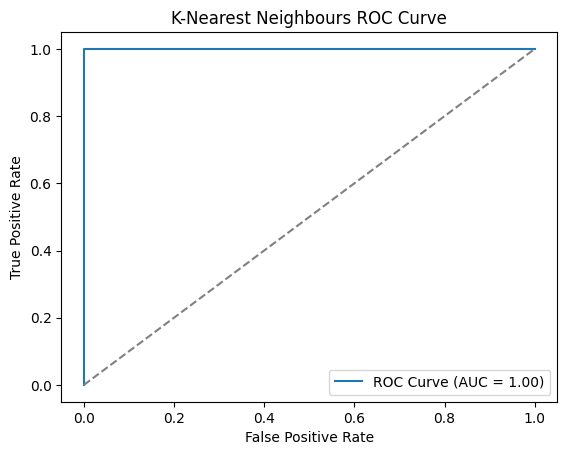

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         5

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



In [10]:
knn = KNeighborsClassifier(n_neighbors=2, metric='euclidean')
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)
knn_probs = knn.predict_proba(X_test)[:, 1]

plot_confusion_matrix(y_test, knn_pred, title="K-Nearest Neighbours Confusion Matrix")
plot_precision_recall(y_test, knn_probs, model_name="K-Neareset Neighbours")
plot_roc_curve(y_test, knn_probs, model_name="K-Nearest Neighbours")
print(classification_report(y_test, knn_pred))

## Support Vector Classifier

<Figure size 640x480 with 0 Axes>

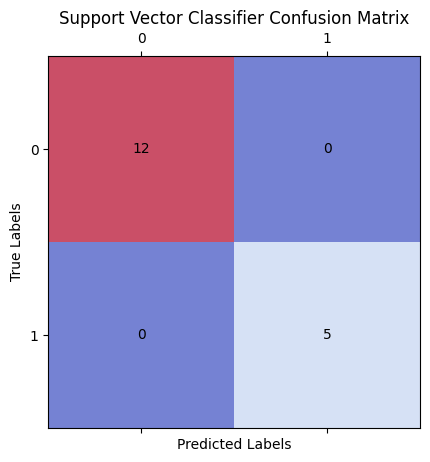

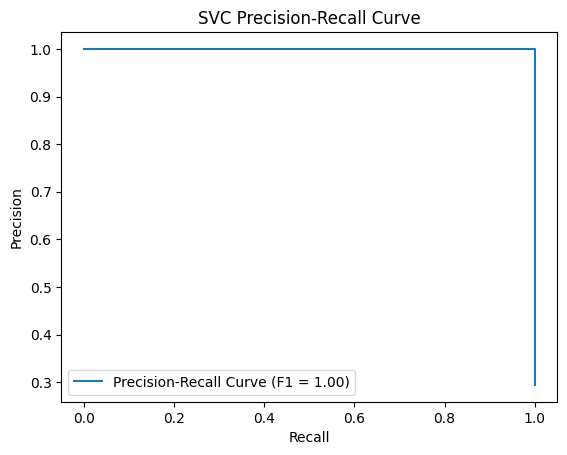

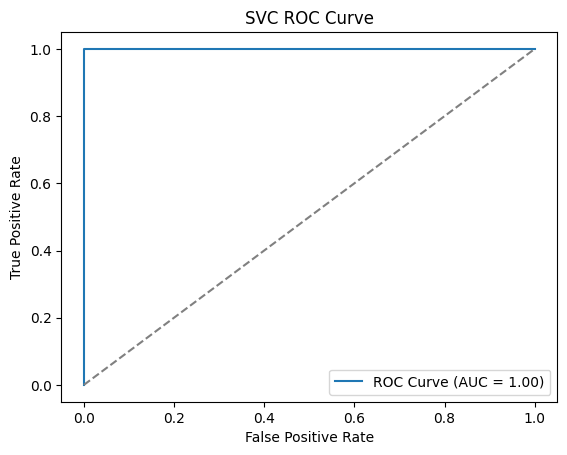

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         5

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



In [11]:
svc = SVC(probability=True, kernel='rbf', C=1.0, random_state=42)
svc.fit(X_train, y_train)

svc_pred = svc.predict(X_test)
svc_probs = svc.predict_proba(X_test)[:, 1]

plot_confusion_matrix(y_test, svc_pred, title="Support Vector Classifier Confusion Matrix")
plot_precision_recall(y_test, svc_probs, model_name="SVC")
plot_roc_curve(y_test, svc_probs, model_name="SVC")
print(classification_report(y_test, svc_pred))

## Gaussian Naive Bayes

<Figure size 640x480 with 0 Axes>

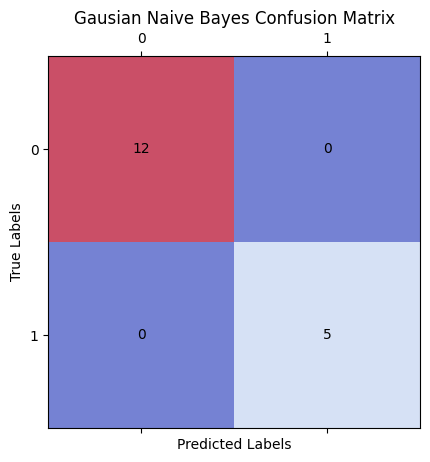

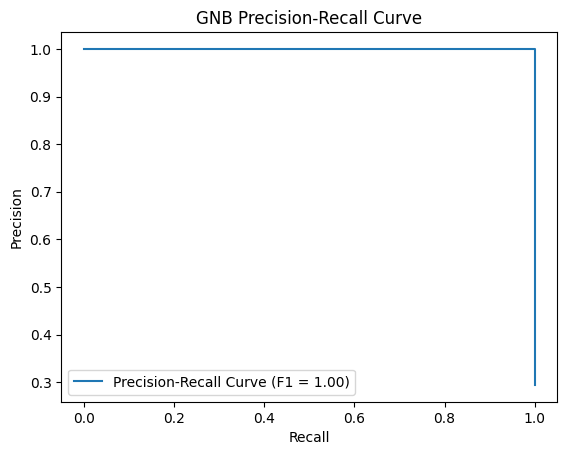

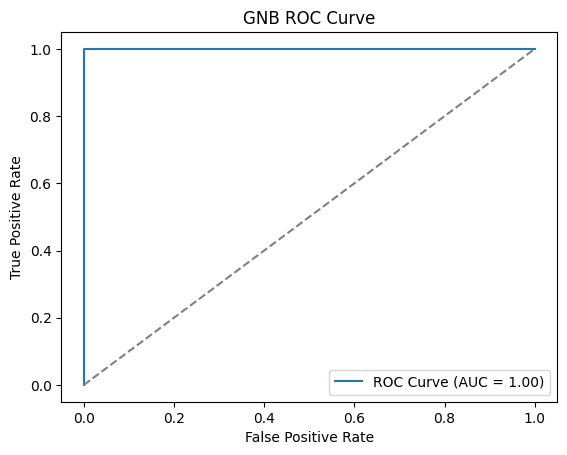

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         5

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



In [12]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

gnb_pred = gnb.predict(X_test)
gnb_probs = gnb.predict_proba(X_test)[:, 1]

plot_confusion_matrix(y_test, gnb_pred, title="Gausian Naive Bayes Confusion Matrix")
plot_precision_recall(y_test, gnb_probs, model_name="GNB")
plot_roc_curve(y_test, gnb_probs, model_name="GNB")
print(classification_report(y_test, gnb_pred))

## XGBoost

In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                    random_state=42)
xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)
xgb_probs = xgb.predict_proba(X_test)[:, 1]

plot_confusion_matrix(y_test, xgb_pred, title="XGBoost Confusion Matrix")
plot_precision_recall(y_test, xgb_probs, model_name="XGBoost")
plot_roc_curve(y_test, xgb_probs, model_name="XGBoost")
print(classification_report(y_test, xgb_pred))